In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")
plt.rcParams["image.cmap"] = "viridis"

In [4]:
dev = tch.device("cuda")
dtype = tch.float32

In [5]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [6]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [96]:
def add_noise(x: Tensor, noise: Tensor, alpha: float | list | np.ndarray | Tensor) -> Tensor:
    if not isinstance(alpha, Tensor):
        if isinstance(alpha, np.ndarray):
            array = alpha
        elif isinstance(alpha, list):
            array = np.array(alpha)
        else:
            array = np.array([alpha] * x.shape[0])
        alpha = tch.from_numpy(array).to(x.device).type(x.dtype)

    alpha = alpha.reshape((-1, 1, 1))
    
    return alpha.sqrt() * x + (1 - alpha).sqrt() * noise

def sample_step(model: nn.Module, x: Tensor, alpha: float, beta: float, t: int) -> Tensor:
    z = tch.randn_like(x) if t > 1 else tch.zeros_like(x)
    return (1 / np.sqrt(1 - beta)) * (x - (beta / np.sqrt(1 - alpha)) * model.forward(x)) + np.sqrt(beta) * z

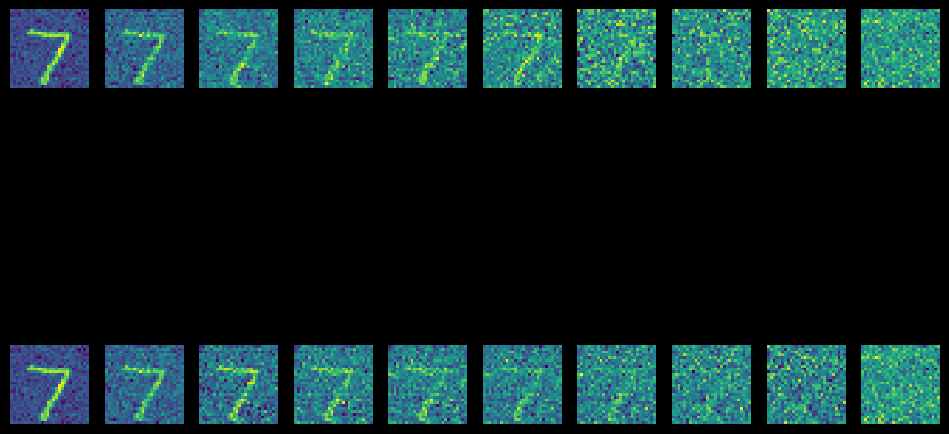

In [67]:
def cosine_schedule(t: int, max_t: int) -> tuple[float, float]:
    "Returns: (alpha, beta)"
    s = 0.008

    def f(t: int) -> float:
        return np.cos((t / max_t + s) / (1 + s) * (np.pi / 2))

    alpha = f(t) / f(0)
    beta = min(1 - f(t) / f(t - 1), 0.999)
    return (alpha, beta)

n = 10
x = make_images(test_images[0:1])
y = x
fig, axs = plt.subplots(2, n)
for t in range(n):
    (alpha, beta) = cosine_schedule(t + 1, n)
    noise = tch.randn_like(x)
    z = add_noise(x, noise, alpha)
    y = add_noise(y, noise, 1 - beta)
    for (row, img) in enumerate([z, y]):
        img = img.detach().cpu().numpy()[0]
        ax = axs[row, t]
        ax.axis('off')
        ax.imshow(img, interpolation='nearest')
fig.show()

In [89]:
def sample_fig(model: nn.Module, x: Tensor, n_steps: int):
    model.train(False)

    n = 10
    draw_steps = [(i * n_steps) // (n - 1) for i in range(n)]
    fig, axs = plt.subplots(x.shape[0], n)
    for i in range(n_steps + 1):
        try:
            col = draw_steps.index(i)
        except ValueError:
            pass
        else:
            images = x.detach().cpu().numpy()
            for row, img in enumerate(images):
                ax = axs[row, col]
                ax.axis('off')
                ax.imshow(img, interpolation='nearest')
        
        t = n_steps - i
        if t == 0:
            break
        (alpha, beta) = cosine_schedule(t, n_steps)
        x = sample_step(model, x, alpha, beta, t)

    return fig

In [146]:
from genpg.model import UNet

image_dims = test_images.shape[1:]

model = UNet([[1, 16, 16], [16, 32, 32], [32, 64, 64]], [64, 256, 256, 64], 3).to(dev)
print(model)

UNet(
  (down): ModuleList(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
 

In [147]:
batch_size = 256
n_steps = 100

optim = tch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
)

'epoch = 39'

{'loss': np.float64(0.04411922996031477)}

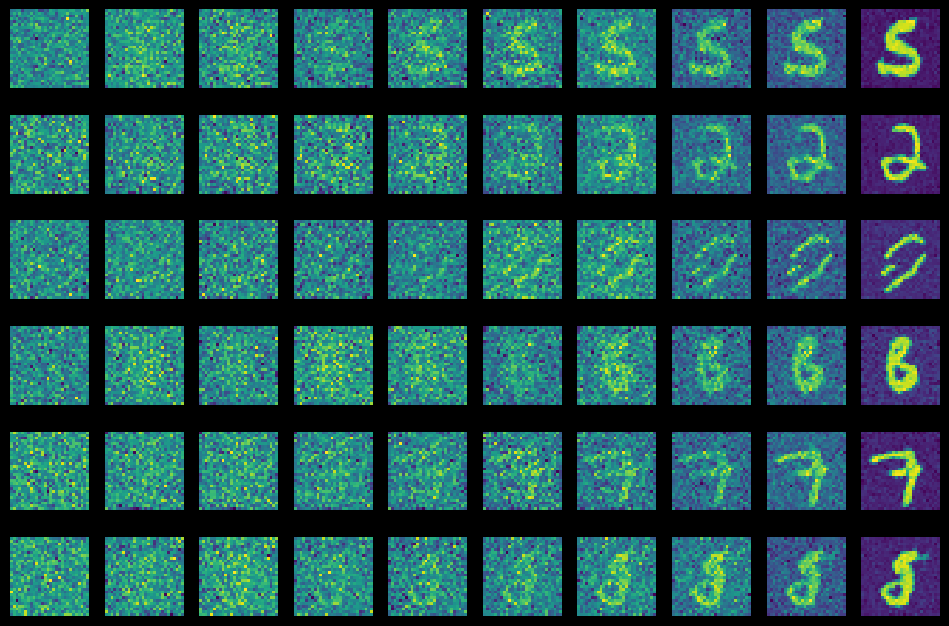

In [148]:
from torch.nn.functional import mse_loss
from genpg.dataset import generate_batches
from genpg.utils import Accum
from genpg.notebook import Display

display = Display()
test_x = tch.randn((6, *image_dims), device=dev)

for epoch in range(40):
    model.train(True)

    train_stats = Accum("loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        model.zero_grad()
        
        ts = np.random.randint(1, n_steps + 1, images.shape[0])
        alpha = [cosine_schedule(t, n_steps)[0] for t in ts]

        noise = tch.randn_like(images)
        x = add_noise(images, noise, alpha)
        y = model.forward(x)

        loss = mse_loss(y, noise)

        loss.backward()
        optim.step()

        train_stats.append(loss.item())

    fig = sample_fig(model, test_x, n_steps)

    display.clear()
    display.update(f"{epoch = }")
    display.update(train_stats.mean())
    display.update(fig)
    plt.close()



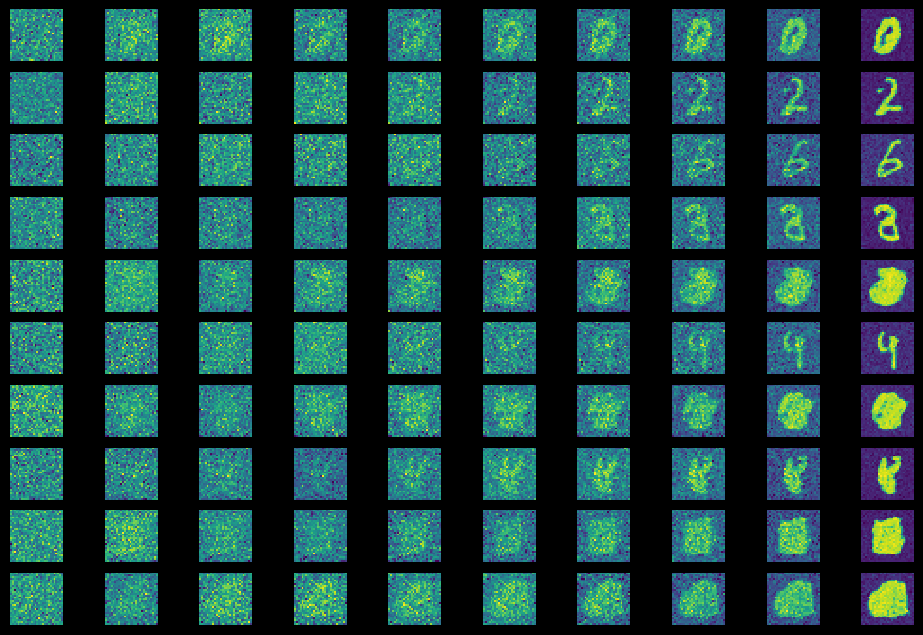

In [149]:
sample_fig(model, tch.randn((10, *image_dims), device=dev), n_steps).show()

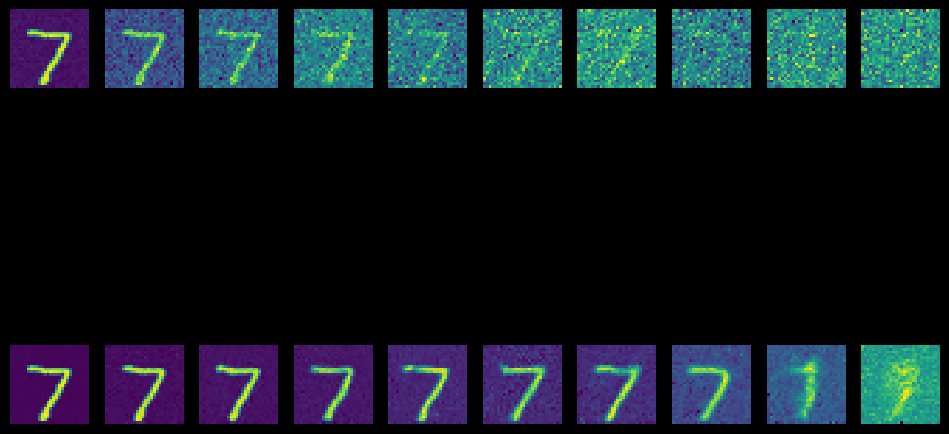

In [150]:
image = make_images(test_images[0:1])
n = 10
fig, axs = plt.subplots(2, n)

for col in range(n):
    alpha = cosine_schedule(1 + col * n_steps // n, n_steps)[0]
    noise = tch.randn_like(x)
    x = add_noise(image, noise, alpha)
    y = model.forward(x)
    restored = (x - np.sqrt(1 - alpha) * y) / np.sqrt(alpha)

    for row, img in enumerate([x, restored]):
        img = img.detach().cpu().numpy()[0]
        ax = axs[row, col]
        ax.axis('off')
        ax.imshow(img, interpolation='nearest')